# Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols


import scipy
import scipy as sp
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import f
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV, chi2, SelectKBest
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import plot_importance

from vecstack import stacking

from datetime import datetime
import pickle


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn')

%matplotlib inline

# Clean

In [2]:
pump_variables = pd.read_csv('pump_features.csv')

In [3]:
pump_ind_var = pd.read_csv('pump_target.csv')

In [4]:
df = pump_variables.merge(pump_ind_var, on='id')

In [5]:
df.shape

(59400, 41)

In [6]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [7]:
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [8]:
df.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [9]:
features = df.drop(columns=['id','status_group','date_recorded', 
                            'funder', 'installer', 'wpt_name', 'subvillage',
                           'lga', 'ward', 'scheme_name', 'public_meeting', 'scheme_management',
                           'permit', 'recorded_by', 'extraction_type_group',
                           'extraction_type_class', 'management', 'quantity', 'payment', 'waterpoint_type'])

In [10]:
statusdict = {'functional':0,
              'functional needs repair':0,
              'non functional':1
             }

In [11]:
target = df.status_group.replace(statusdict)

In [12]:
def cat_num_pipeline(some_df): 
    object_cols = some_df.select_dtypes(['object']).columns
    num_cols = some_df.select_dtypes(['int64']).columns
    #find ones with less than 30 unique values
    cat_names = []
    for i in object_cols:
        if some_df[i].nunique() < 30:
            cat_names.append(i)

    #new dataframe with only those category columns also label encoded
    catted = some_df[cat_names].apply(lambda x: x.astype('category').cat.codes)
    nummed = some_df[num_cols]
    cat_encoded_with_num = pd.concat([catted, nummed], axis=1)
    return cat_encoded_with_num

In [13]:
def cat_pipeline(somedataframe):  
    #find the categorical columns
    object_cols = somedataframe.select_dtypes(['object']).columns

    #find ones with less than 30 unique values
    cat_names = []
    for i in object_cols:
        if features[i].nunique() < 30:
            cat_names.append(i)

    #new dataframe with only those category columns also label encoded
    catted = somedataframe[cat_names].apply(lambda x: x.astype('category').cat.codes)
    
    return catted

In [14]:
trans_features = cat_num_pipeline(features)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44550, 21), (14850, 21), (44550,), (14850,))

# EDA

In [17]:
df.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [18]:
corr = pd.concat([trans_features, target], axis=1).corr()

In [19]:
corr

,basin,region,extraction_type,management_group,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type_group,gps_height,num_private,region_code,district_code,population,construction_year,status_group
basin,1.000000,-0.114880,0.167450,-0.068413,-0.029961,-0.075529,0.044721,-0.026707,-0.061457,-0.074808,0.031636,0.013518,-0.161768,0.018325,0.139887,0.189692,0.066899,0.268151,0.050699
region,-0.114880,1.000000,0.217222,-0.023112,0.056709,-0.073382,0.129883,0.034766,-0.156225,-0.140439,-0.010899,0.257183,-0.323833,0.037351,0.109343,-0.021688,-0.004416,-0.141681,0.091277
extraction_type,0.167450,0.217222,1.000000,-0.037540,0.127332,-0.109225,0.158023,0.001082,-0.327352,-0.349526,-0.229795,0.306034,-0.237886,0.017254,0.101472,0.026746,0.065397,-0.061434,0.121220
management_group,-0.068413,-0.023112,-0.037540,1.000000,-0.088186,-0.000058,-0.015640,-0.063840,0.125469,0.116906,-0.103702,0.078511,0.025610,-0.034356,0.033028,0.015617,-0.022093,-0.074380,0.021179
payment_type,-0.029961,0.056709,0.127332,-0.088186,1.000000,-0.047366,0.167419,0.006905,-0.164325,-0.173454,-0.037780,0.025069,-0.097431,0.008963,0.140829,0.093541,0.034478,-0.016861,0.069421
water_quality,-0.075529,-0.073382,-0.109225,-0.000058,-0.047366,1.000000,-0.145333,-0.031869,0.083627,0.097019,0.083834,-0.149837,0.140459,-0.001533,-0.063508,-0.061223,-0.031126,0.050884,-0.005762
quality_group,0.044721,0.129883,0.158023,-0.015640,0.167419,-0.145333,1.000000,0.011646,-0.160597,-0.188973,-0.125602,0.189091,-0.092273,-0.006318,0.084583,0.037939,0.024627,-0.008012,0.161529
quantity_group,-0.026707,0.034766,0.001082,-0.063840,0.006905,-0.031869,0.011646,1.000000,-0.004138,-0.000585,0.117300,0.010060,-0.030781,0.003544,-0.066812,-0.027803,0.031487,-0.008484,-0.147274
source,-0.061457,-0.156225,-0.327352,0.125469,-0.164325,0.083627,-0.160597,-0.004138,1.000000,0.943818,-0.202467,0.039558,0.121495,-0.007913,-0.129150,-0.051498,-0.089433,-0.007553,-0.105361
source_type,-0.074808,-0.140439,-0.349526,0.116906,-0.173454,0.097019,-0.188973,-0.000585,0.943818,1.000000,-0.087867,0.025987,0.124323,-0.010613,-0.141470,-0.068146,-0.090925,-0.025503,-0.087308


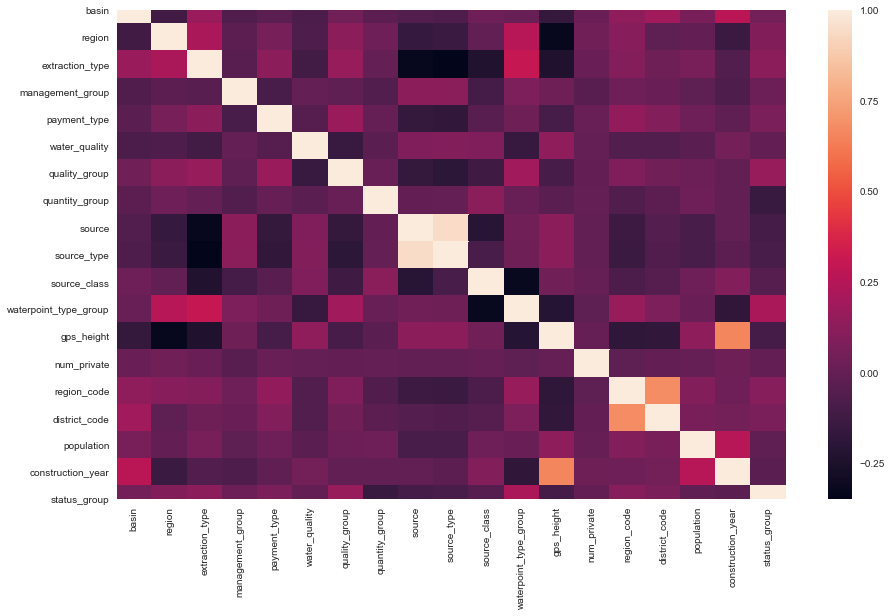

In [20]:
plt.figure(figsize=(15,9))
sns.heatmap(corr)
plt.show()

In [21]:
df.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(trans_features, target, random_state=0)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44550, 18), (14850, 18), (44550,), (14850,))

# Categorical and Numerical Feature Models

## Baseline

In [278]:
len(X_test)

14850

In [279]:
y_test

11524    0
16731    1
48776    0
23300    0
25270    0
        ..
5954     0
58321    0
44690    0
39643    0
31638    0
Name: status_group, Length: 14850, dtype: int64

In [280]:
basepreds = [1 for i in range(len(y_test))]

In [281]:
f1_score(basepreds, y_test), accuracy_score(basepreds, y_test)

(0.5559391257840229, 0.384983164983165)

In [282]:
results = {}

In [283]:
results['model'] = ('f1', 'accuracy')

In [284]:
results['baseline'] = (0.5559391257840229, 0.384983164983165)

In [285]:
results

{'model': ('f1', 'accuracy'),
 'baseline': (0.5559391257840229, 0.384983164983165)}

## Random Forest

In [286]:
rfc = RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=500, max_depth=3)

In [287]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [288]:
preds_rfc_numcat = rfc.predict(X_test)

In [289]:
f1_score(y_test, preds_rfc_numcat), accuracy_score(y_test, preds_rfc_numcat),

(0.5858729033782187, 0.7639057239057239)

In [290]:
results['rf_numcat1'] = (0.5858729033782187, 0.7639057239057239)

In [291]:
results

{'model': ('f1', 'accuracy'),
 'baseline': (0.5559391257840229, 0.384983164983165),
 'rf_numcat1': (0.5858729033782187, 0.7639057239057239)}

## KNN

In [292]:
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean',
                        n_jobs=-1)

In [293]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='uniform')

In [294]:
kpreds = knn.predict(X_test)

In [295]:
f1_score(y_test, kpreds), accuracy_score(y_test, kpreds)

(0.617157242447715, 0.7337373737373737)

In [296]:
results['knn_numcat1'] = (0.617157242447715, 0.7337373737373737)

In [297]:
results

{'model': ('f1', 'accuracy'),
 'baseline': (0.5559391257840229, 0.384983164983165),
 'rf_numcat1': (0.5858729033782187, 0.7639057239057239),
 'knn_numcat1': (0.617157242447715, 0.7337373737373737)}

## Logistic

In [298]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', C = .1,
      penalty="l1")

In [299]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [300]:
preds = lr.predict(X_test)

In [301]:
f1_score(y_test, preds), accuracy_score(y_test, preds)

(0.5507456670697299, 0.6247138047138047)

In [302]:
results['log_numcat1'] = (0.5507456670697299, 0.6247138047138047)

In [303]:
results

{'model': ('f1', 'accuracy'),
 'baseline': (0.5559391257840229, 0.384983164983165),
 'rf_numcat1': (0.5858729033782187, 0.7639057239057239),
 'knn_numcat1': (0.617157242447715, 0.7337373737373737),
 'log_numcat1': (0.5507456670697299, 0.6247138047138047)}

# Only Categorical Feature Models

## Baseline

In [304]:
len(X_test)

14850

In [305]:
y_test

11524    0
16731    1
48776    0
23300    0
25270    0
        ..
5954     0
58321    0
44690    0
39643    0
31638    0
Name: status_group, Length: 14850, dtype: int64

In [306]:
basepreds = [1 for i in range(len(y_test))]

In [307]:
f1_score(basepreds, y_test), accuracy_score(basepreds, y_test)

(0.5559391257840229, 0.384983164983165)

## RandomForest

In [308]:
transc_features = cat_pipeline(features)

In [309]:
X_train, X_test, y_train, y_test = train_test_split(transc_features, target, random_state=0)

In [310]:
rfc = RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=500, max_depth=3)

In [311]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [312]:
predsrfc1 = rfc.predict(X_test)

In [313]:
predsrfc1

array([0, 1, 0, ..., 0, 0, 0])

In [314]:
f1_score(y_test, predsrfc1), accuracy_score(y_test, predsrfc1), 

(0.5803539612780615, 0.762087542087542)

In [315]:
results['rf_cat1'] = ((0.5803539612780615, 0.762087542087542))

In [316]:
results

{'model': ('f1', 'accuracy'),
 'baseline': (0.5559391257840229, 0.384983164983165),
 'rf_numcat1': (0.5858729033782187, 0.7639057239057239),
 'knn_numcat1': (0.617157242447715, 0.7337373737373737),
 'log_numcat1': (0.5507456670697299, 0.6247138047138047),
 'rf_cat1': (0.5803539612780615, 0.762087542087542)}

## KNN

In [317]:
transc_features = cat_pipeline(features)

X_train, X_test, y_train, y_test = train_test_split(transc_features, target, random_state=0)

In [318]:
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean',
                        n_jobs=-1)

In [319]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='uniform')

In [320]:
kpreds = knn.predict(X_test)

In [321]:
f1_score(y_test, kpreds), accuracy_score(y_test, kpreds)

(0.7162084214574121, 0.8012121212121213)

In [322]:
results['knn_cat1'] = ((0.7162084214574121, 0.8012121212121213))

In [323]:
results

{'model': ('f1', 'accuracy'),
 'baseline': (0.5559391257840229, 0.384983164983165),
 'rf_numcat1': (0.5858729033782187, 0.7639057239057239),
 'knn_numcat1': (0.617157242447715, 0.7337373737373737),
 'log_numcat1': (0.5507456670697299, 0.6247138047138047),
 'rf_cat1': (0.5803539612780615, 0.762087542087542),
 'knn_cat1': (0.7162084214574121, 0.8012121212121213)}

## Logistic

In [325]:
transc_features = cat_pipeline(features)

X_train, X_test, y_train, y_test = train_test_split(transc_features, target, random_state=0)

In [326]:
lr1 = LogisticRegression(solver='liblinear', class_weight='balanced', C = .1,
      penalty="l1")

In [327]:
lr1.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [328]:
lr1preds = lr1.predict(X_test)

f1_score(y_test, lr1preds), accuracy_score(y_test, lr1preds)

(0.55118237771299, 0.6268013468013468)

In [329]:
results['lr_cat1'] = (0.55118237771299, 0.6268013468013468)

In [330]:
results

{'model': ('f1', 'accuracy'),
 'baseline': (0.5559391257840229, 0.384983164983165),
 'rf_numcat1': (0.5858729033782187, 0.7639057239057239),
 'knn_numcat1': (0.617157242447715, 0.7337373737373737),
 'log_numcat1': (0.5507456670697299, 0.6247138047138047),
 'rf_cat1': (0.5803539612780615, 0.762087542087542),
 'knn_cat1': (0.7162084214574121, 0.8012121212121213),
 'lr_cat1': (0.55118237771299, 0.6268013468013468)}

# KNN CAT GRID

In [331]:
grid = {
    'n_neighbors': [7,9,11],
    'weights' : ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [332]:
knn = KNeighborsClassifier()

In [333]:
lr_cv = GridSearchCV(
    estimator = knn,
    param_grid = grid,
    scoring = 'f1',
    verbose=1,
    iid=False,
    cv=5)

In [334]:
lr_cv.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   53.8s finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [7, 9, 11],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [335]:
lr_cv.best_params_

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

In [336]:
lr_cv.best_score_

0.727155605899072

In [337]:
preds = lr_cv.best_estimator_.predict(X_test)

In [338]:
f1_score(preds, y_test), accuracy_score(preds, y_test)

(0.7268549545236955, 0.8078787878787879)

In [339]:
results['knn_grid'] = (0.7268549545236955, 0.8078787878787879)

In [340]:
results

{'model': ('f1', 'accuracy'),
 'baseline': (0.5559391257840229, 0.384983164983165),
 'rf_numcat1': (0.5858729033782187, 0.7639057239057239),
 'knn_numcat1': (0.617157242447715, 0.7337373737373737),
 'log_numcat1': (0.5507456670697299, 0.6247138047138047),
 'rf_cat1': (0.5803539612780615, 0.762087542087542),
 'knn_cat1': (0.7162084214574121, 0.8012121212121213),
 'lr_cat1': (0.55118237771299, 0.6268013468013468),
 'knn_grid': (0.7268549545236955, 0.8078787878787879)}

# Final Modeling

In [341]:
transdf = pd.concat([trans_features, target], axis=1)

In [342]:
transdf

,basin,region,extraction_type,management_group,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type_group,gps_height,num_private,region_code,district_code,population,construction_year,status_group
0,1,3,3,4,0,6,2,1,8,6,0,1,1390,0,11,5,109,1999,0
1,4,9,3,4,2,6,2,2,5,3,1,1,1399,0,20,2,280,2010,0
2,5,8,3,4,5,6,2,1,0,1,1,1,686,0,21,4,250,2009,0
3,7,12,14,4,2,6,2,0,3,0,0,1,263,0,90,63,58,1986,1
4,4,4,3,1,2,6,2,3,5,3,1,1,0,0,18,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,5,6,3,4,5,6,2,1,8,6,0,1,1210,0,3,5,125,1999,0
59396,6,3,3,4,0,6,2,1,6,4,1,1,1212,0,11,4,56,1996,0
59397,6,10,15,4,1,1,1,1,3,0,0,3,0,0,12,7,0,0,0
59398,6,2,8,4,2,6,2,2,7,5,0,3,0,0,1,4,0,0,0


In [343]:
trans_features

,basin,region,extraction_type,management_group,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type_group,gps_height,num_private,region_code,district_code,population,construction_year
0,1,3,3,4,0,6,2,1,8,6,0,1,1390,0,11,5,109,1999
1,4,9,3,4,2,6,2,2,5,3,1,1,1399,0,20,2,280,2010
2,5,8,3,4,5,6,2,1,0,1,1,1,686,0,21,4,250,2009
3,7,12,14,4,2,6,2,0,3,0,0,1,263,0,90,63,58,1986
4,4,4,3,1,2,6,2,3,5,3,1,1,0,0,18,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,5,6,3,4,5,6,2,1,8,6,0,1,1210,0,3,5,125,1999
59396,6,3,3,4,0,6,2,1,6,4,1,1,1212,0,11,4,56,1996
59397,6,10,15,4,1,1,1,1,3,0,0,3,0,0,12,7,0,0
59398,6,2,8,4,2,6,2,2,7,5,0,3,0,0,1,4,0,0


In [26]:
dfx = pd.concat([features[features.longitude != 0], target], axis=1)

/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


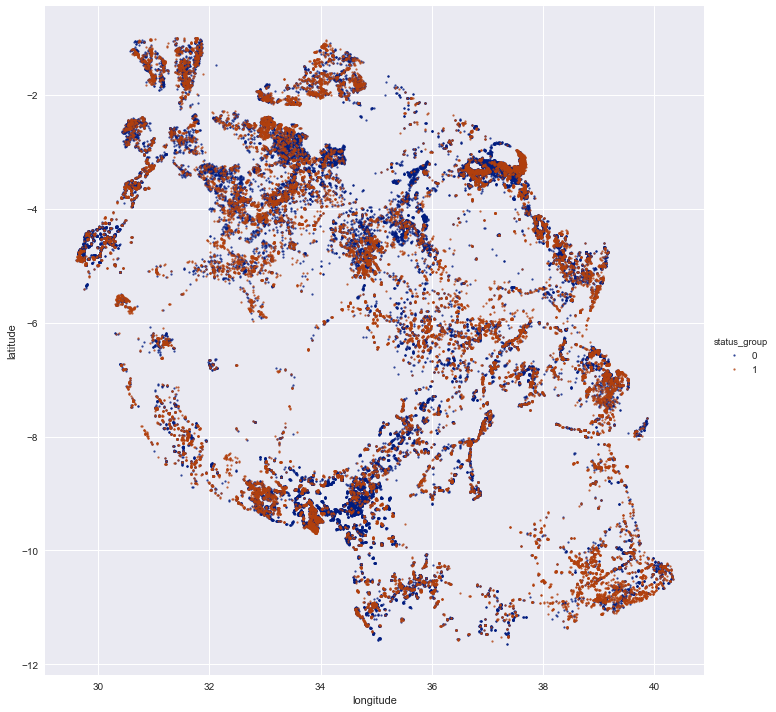

In [27]:
sns.lmplot(x='longitude', y='latitude', data=dfx, hue='status_group', aspect=1, palette='dark', fit_reg=False, size=10, scatter_kws = {'s': 5})

plt.show()

http://www.scielo.org.za/scielo.php?script=sci_arttext&pid=S1021-20192009000100002

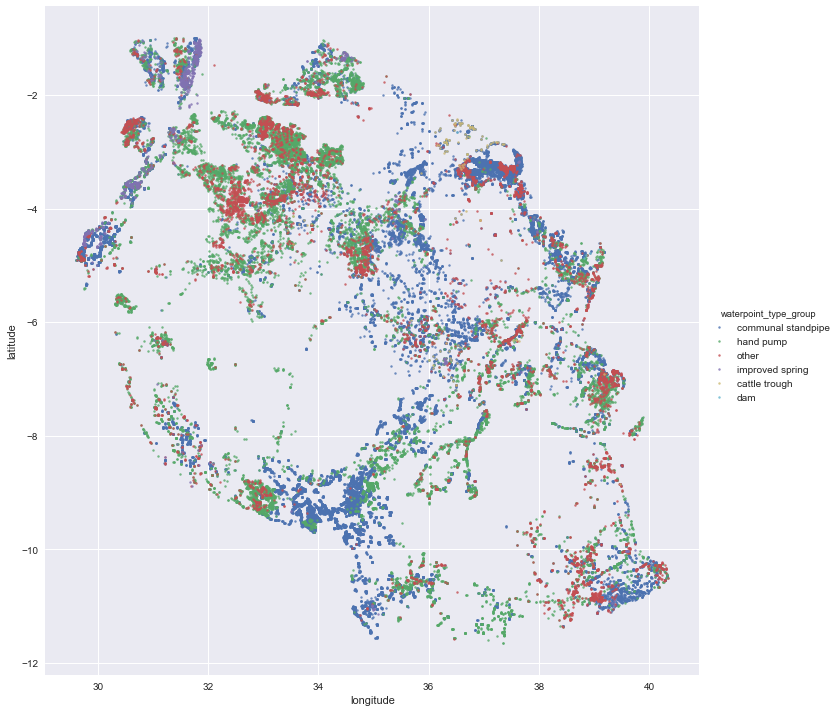

In [354]:
sns.lmplot(x='longitude', y='latitude', data=dfx, hue='waterpoint_type_group', aspect=1, fit_reg=False, size=10, scatter_kws = {'s': 6})
plt.show()

In [347]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))

    return alg
#     feat_imp = pd.Series(alg.get_booster().get_fscore())
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [348]:
df_alg = pd.concat([trans_features, target], axis=1)

In [349]:
predictors = trans_features.columns
target = pd.DataFrame(target).columns

In [350]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

alg = modelfit(xgb1, df_alg, predictors, target)

/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : 0.8326
AUC Score (Train): 0.898560


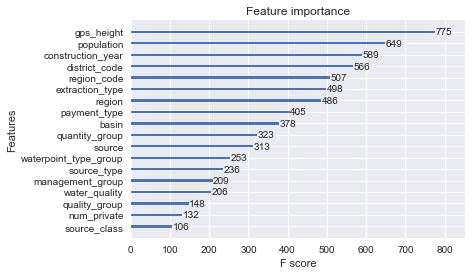

In [351]:

# plot feature importance
plot_importance(alg)


The f-scores in this plot represent how many times the feature was split on. 

In [352]:
alg.get_booster().get_fscore()

{'waterpoint_type_group': 253,
 'payment_type': 405,
 'management_group': 209,
 'source_type': 236,
 'source_class': 106,
 'construction_year': 589,
 'water_quality': 206,
 'extraction_type': 498,
 'region_code': 507,
 'population': 649,
 'quality_group': 148,
 'basin': 378,
 'district_code': 566,
 'region': 486,
 'quantity_group': 323,
 'source': 313,
 'gps_height': 775,
 'num_private': 132}

In [365]:
df.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [381]:
dfx['pop'] = np.where(dfx.population <180,'<180','>180')

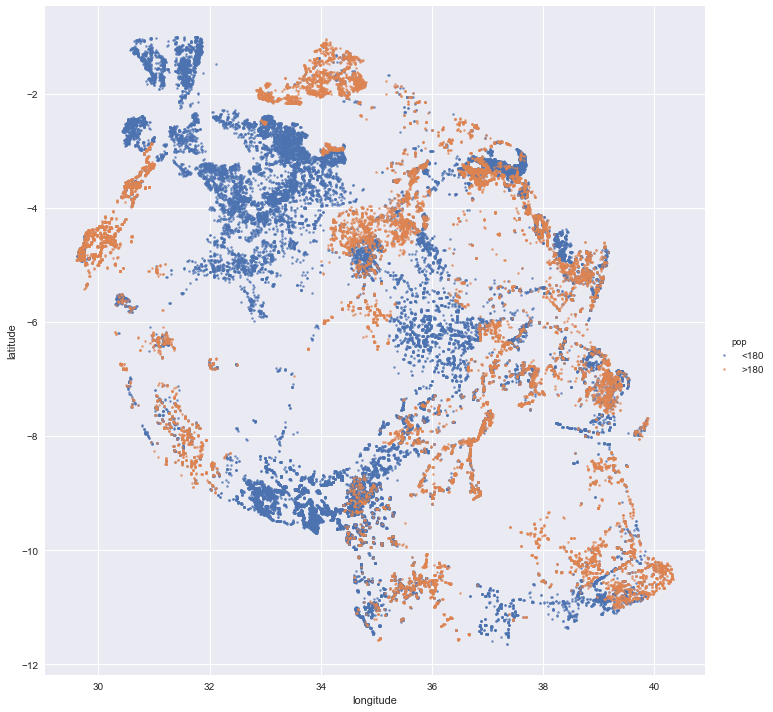

In [383]:
sns.lmplot(x='longitude', y='latitude', data=dfx, hue='pop', aspect=1, fit_reg=False, size=10, scatter_kws = {'s': 6}, palette ='deep')
plt.show()